<a href="https://colab.research.google.com/github/Acheon-stst/Acheon-stst/blob/main/DNSC3288.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from pathlib import Path
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from itertools import product




# Load Datasets


In [ ]:
# Load the main training set (daily sales)
sales = pd.read_csv("sales_train.csv")

# Kaggle test set
test  = pd.read_csv("test.csv")

# Metadata files
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
cats  = pd.read_csv("item_categories.csv")



In [17]:
from google.colab import files
import io
import pandas as pd

# Upload CSV files from your local computer
uploaded = files.upload()


Saving sales_train.csv to sales_train (1).csv


In [19]:
uploaded.keys()


dict_keys(['sales_train (1).csv'])

In [22]:
sales = pd.read_csv(
    io.StringIO(uploaded['sales_train (1).csv'].decode('utf-8'))
)


# Data Analysis

In [31]:
# Provide (rows, columns)
sales.shape


(2935849, 6)

In [32]:
# column names
sales.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [26]:
sales.isnull().any()


,0
date,False
date_block_num,False
shop_id,False
item_id,False
item_price,False
item_cnt_day,False


In [27]:
sales.describe()


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


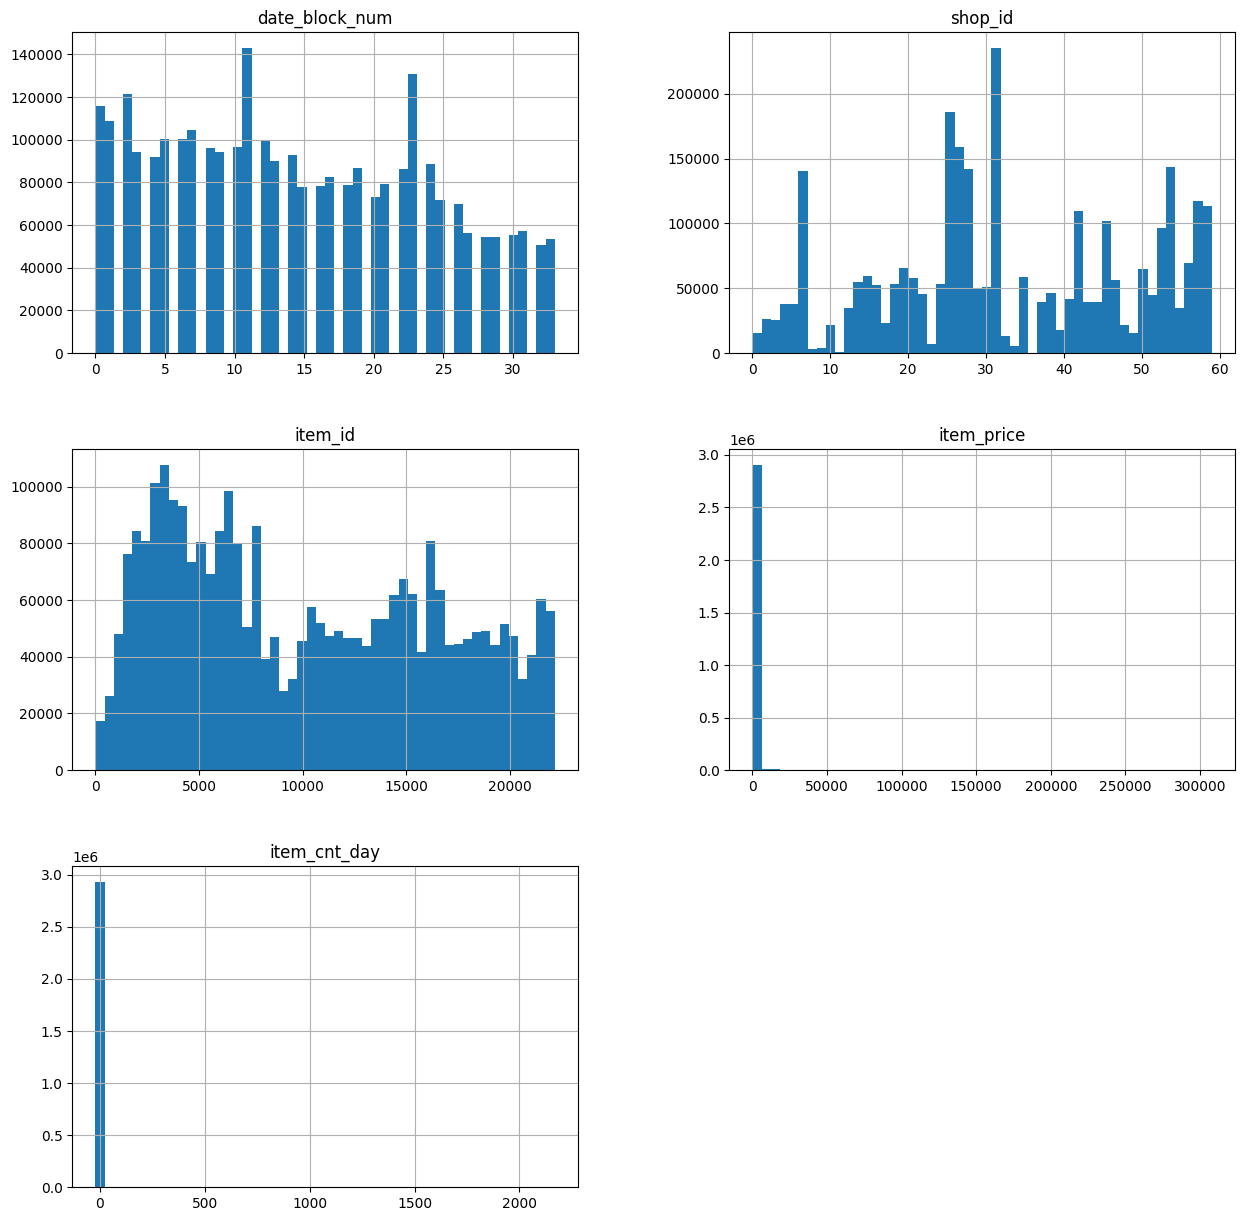

In [28]:
histogram = sales.hist(bins=50, figsize=(15, 15))


 # Cleaning & Preprocessing the raw sales data

In [ ]:
# Kaggle metric clips predictions to [0,20]
sales["item_cnt_day"] = sales["item_cnt_day"].clip(0, 20)

# Convert daily data → monthly data since Kaggle expects monthly prediction, not daily
# Aggregate total sales per (month, shop, item)
monthly = (
    sales.groupby(["date_block_num", "shop_id", "item_id"], as_index=False)
         .agg({"item_cnt_day": "sum",
               "item_price": "mean"})
)

# Renaming item_cnt_day to item_cnt_month
monthly.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)

# Add item_category_id
monthly = monthly.merge(items[["item_id", "item_category_id"]],
                        on="item_id", how="left")





In [ ]:
full_matrix = monthly.copy()

In [34]:
# Item mean sales across all history
item_mean_all = full_matrix.groupby("item_id")["item_cnt_month"].mean().reset_index()
item_mean_all.rename(columns={"item_cnt_month": "item_mean_all"}, inplace=True)
full_matrix = full_matrix.merge(item_mean_all, on="item_id", how="left")

# Shop mean sales
shop_mean_all = full_matrix.groupby("shop_id")["item_cnt_month"].mean().reset_index()
shop_mean_all.rename(columns={"item_cnt_month": "shop_mean_all"}, inplace=True)
full_matrix = full_matrix.merge(shop_mean_all, on="shop_id", how="left")

# Category mean
cat_mean_all = full_matrix.groupby("item_category_id")["item_cnt_month"].mean().reset_index()
cat_mean_all.rename(columns={"item_cnt_month": "cat_mean_all"}, inplace=True)
full_matrix = full_matrix.merge(cat_mean_all, on="item_category_id", how="left")


# Creating a full shop-item-month matrix


In [35]:
# Missing combinations must be filled → assume 0 sales
# List unique shops, items, and months
train_matrix = monthly[["date_block_num", "shop_id", "item_id"]].copy()

# Add test rows (month 34)
test["date_block_num"] = 34
test_matrix = test[["date_block_num", "shop_id", "item_id"]].copy()

full_matrix = pd.concat([train_matrix, test_matrix], ignore_index=True).drop_duplicates()

# Merge true monthly sales
full_matrix = full_matrix.merge(
    monthly,
    on=["date_block_num", "shop_id", "item_id"],
    how="left"
)

# Missing sales → 0
full_matrix["item_cnt_month"] = full_matrix["item_cnt_month"].fillna(0)

# Add category
full_matrix = full_matrix.merge(items[["item_id", "item_category_id"]],
                                on="item_id", how="left")


print(full_matrix.shape)


(1823324, 7)


In [36]:
full_matrix.columns

# Handle Duplicate category columns
if "item_category_id_x" in full_matrix.columns:
    full_matrix["item_category_id"] = full_matrix["item_category_id_x"]
    full_matrix.drop(["item_category_id_x", "item_category_id_y"], axis=1, inplace=True)


full_matrix.columns


Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price',
       'item_category_id'],
      dtype='object')

In [37]:
# Generate lag features
# Use past sales to predict future sales
def create_lag(df, col, lags):
    """Create lag features for grouped shop-item sequences."""
    for lag in lags:
        df[f"{col}_lag_{lag}"] = df.groupby(["shop_id", "item_id"])[col].shift(lag)
    return df





In [ ]:
# Lags of sales
full_matrix = create_lag(full_matrix, "item_cnt_month", [1, 2, 3, 6, 12])

# Shop avg sales
shop_avg = full_matrix.groupby(["date_block_num", "shop_id"])["item_cnt_month"].mean().reset_index()
shop_avg.rename(columns={"item_cnt_month": "shop_avg_sales"}, inplace=True)
full_matrix = full_matrix.merge(shop_avg, on=["date_block_num", "shop_id"], how="left")
full_matrix = create_lag(full_matrix, "shop_avg_sales", [1])






In [ ]:
# Item avg sales
item_avg = full_matrix.groupby(["date_block_num", "item_id"])["item_cnt_month"].mean().reset_index()
item_avg.rename(columns={"item_cnt_month": "item_avg_sales"}, inplace=True)
full_matrix = full_matrix.merge(item_avg, on=["date_block_num", "item_id"], how="left")
full_matrix = create_lag(full_matrix, "item_avg_sales", [1])

In [ ]:
# Category avg sales
cat_avg = full_matrix.groupby(["date_block_num", "item_category_id"])["item_cnt_month"].mean().reset_index()
cat_avg.rename(columns={"item_cnt_month": "category_avg_sales"}, inplace=True)
full_matrix = full_matrix.merge(cat_avg, on=["date_block_num", "item_category_id"], how="left")
full_matrix = create_lag(full_matrix, "category_avg_sales", [1])

# TRAIN–VALIDATION SPLIT

In [ ]:
# Use month 33 (Oct 2015) as validation

train = full_matrix[full_matrix["date_block_num"] < 33]
val   = full_matrix[full_matrix["date_block_num"] == 33]

FEATURES = [
    c for c in full_matrix.columns
    if c not in ["item_cnt_month", "item_price_avg"]
]

X_train, y_train = train[FEATURES], train["item_cnt_month"]
X_val, y_val     = val[FEATURES],   val["item_cnt_month"]

print("Training rows:", X_train.shape, "Validation rows:", X_val.shape)


Training rows: (1577593, 16) Validation rows: (31531, 16)


# TRAIN XGBOOST MODEL


In [ ]:
model = XGBRegressor(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist"
)

print("Training model...")
model.fit(X_train, y_train)




Training model...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

# VALIDATION EVALUATION

In [ ]:
val_pred = np.clip(model.predict(X_val), 0, 20)
rmse = sqrt(mean_squared_error(y_val, val_pred))
print("Validation RMSE:", rmse)

Validation RMSE: 5.085467564895916


# Preparing test dataset

In [ ]:
for col in ["item_category_id", "item_category_id_x", "item_category_id_y"]:
    if col in test.columns:
        test.drop(col, axis=1, inplace=True)

# Rebuild clean category column
test = test.merge(
    items[["item_id", "item_category_id"]],
    on="item_id",
    how="left"
)


# Restore date_block_num
test["date_block_num"] = 34

# Pull last-month features
last_month_features = full_matrix[full_matrix["date_block_num"] == 33][FEATURES].drop_duplicates()

# Merge engineered features into test
test_ff = test.merge(
    last_month_features,
    on=["shop_id", "item_id", "item_category_id"],
    how="left"
)

# Restore date_block_num again (merge can drop it)
test_ff["date_block_num"] = 34

test_ff.fillna(0, inplace=True)

X_test = test_ff[FEATURES]


test_pred = np.clip(model.predict(X_test), 0, 20)


# Submission

In [ ]:
submission = pd.DataFrame({
    "ID": test["ID"],
    "item_cnt_month": test_pred
})

submission.to_csv("submission.csv", index=False)

submission

,ID,item_cnt_month
0,0,0.714192
1,1,0.841948
2,2,1.362786
3,3,0.713629
4,4,0.714192
...,...,...
214195,214195,1.032882
214196,214196,0.647461
214197,214197,0.666214
214198,214198,0.623798


In [ ]:
submission.to_csv("Group8_submission.csv", index =False)